In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import scipy
import pandas as pd
import pathlib
import tensorflow as tf
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.utils import resample
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import classification_report
import numpy as np
from tensorflow.keras import layers

In [ ]:
train_data_dir = pathlib.Path("/content/drive/MyDrive/FLIP AI Proj/Body Type dataset/car_body_type/train")
test_data_dir = pathlib.Path("/content/drive/MyDrive/FLIP AI Proj/Body Type dataset/car_body_type/test")
val_data_dir = pathlib.Path("/content/drive/MyDrive/FLIP AI Proj/Body Type dataset/car_body_type/valid")

In [ ]:
#count per class
class_names = sorted([dir.name for dir in train_data_dir.glob('*')])

class_names_list = []
train_counts = []
test_counts = []
val_counts = []
for class_name in class_names:
    train_class_dir = train_data_dir / class_name
    test_class_dir = test_data_dir / class_name
    val_class_dir = val_data_dir / class_name

    train_count = len(list(train_class_dir.glob('*.jpg')))
    test_count = len(list(test_class_dir.glob('*.jpg')))
    val_count = len(list(val_class_dir.glob('*.jpg')))

    class_names_list.append(class_name)
    train_counts.append(train_count)
    test_counts.append(test_count)
    val_counts.append(val_count)

data = {
    "Class Name": class_names_list,
    "Train Images": train_counts,
    "Test Images": test_counts,
    "Validation Images": val_counts
}
df = pd.DataFrame(data)
df.reset_index(inplace=True, drop=True)
print(df)


    Class Name  Train Images  Test Images  Validation Images
0  Convertible           811          174                292
1        Coupe           721           79                106
2    Hatchback           701           99                176
3      Pick-Up           759          110                217
4          SUV           854          125                274
5        Sedan           729          109                170
6          VAN           782          106                162


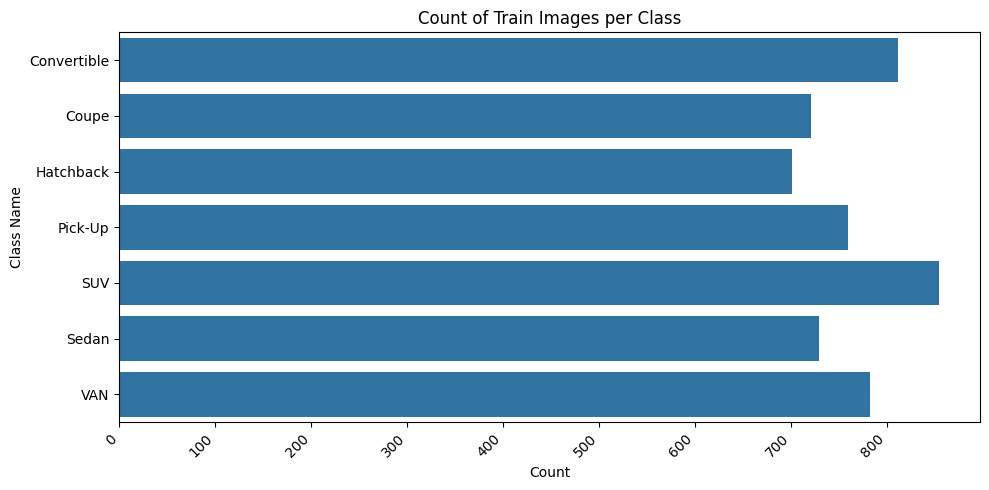

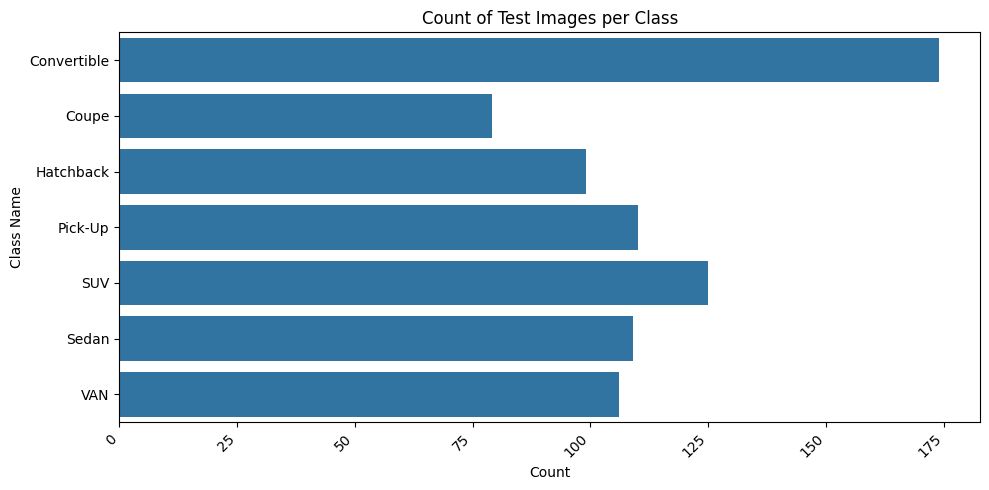

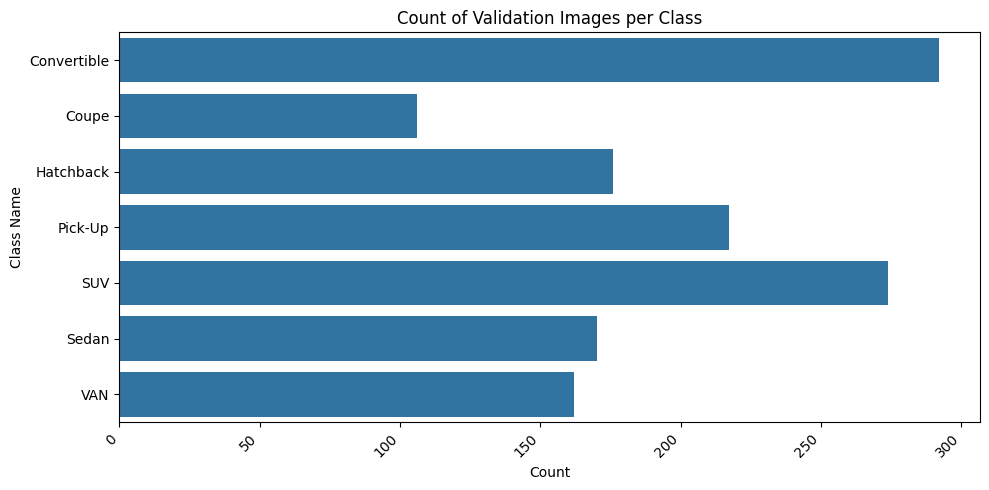

In [ ]:
#class distribution to check imbalance
columns_to_plot = ["Train Images", "Test Images", "Validation Images" ]

def plot_bar_chart(column):
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df, y='Class Name', x=column, orient ='h')
    plt.title(f"Count of {column} per Class")
    plt.xlabel("Count")
    plt.ylabel("Class Name")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

for column in columns_to_plot:
    plot_bar_chart(column)

In [ ]:
#Data preprocessing/preparation
batch_size =32
class_mode = 'categorical'
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_data_dir,
        target_size=(64, 64), batch_size = batch_size, class_mode = class_mode)

# transforming  data in the directory split/validation (677 images)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_data_dir,
        target_size=(64, 64), batch_size = batch_size, class_mode = class_mode)

# tranforming the data in the directory test (118 images)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_data_dir,
        target_size=(64, 64), batch_size=batch_size, class_mode = class_mode)


Found 5357 images belonging to 7 classes.
Found 1397 images belonging to 7 classes.
Found 802 images belonging to 7 classes.


In [ ]:
# Balancing the training dataset
minor_class_samples_train = {
    'convertible': [],
    'coupe': [],
    'hatchback': [],
    'pick-up': [],
    'sedan': [],
    'suv': [],
    'van': []
}

# Extract samples for each class
for class_name, class_index in train_generator.class_indices.items():
    class_name_lower = class_name.lower()
    for i, label in enumerate(train_generator.classes):
        if label == class_index:
            image_path = train_generator.filepaths[i]
            minor_class_samples_train[class_name_lower].append((image_path, label))  # Use lowercase class name

# Get the number of samples in the majority class in the training data
majority_class_samples_train = max(len(samples) for samples in minor_class_samples_train.values())

# Upsample the minority classes in the training data to match the number of samples in the majority class
balanced_samples_train = []
for class_name, samples in minor_class_samples_train.items():
    upsampled_samples_train = resample(samples,
                                       replace=True,
                                       n_samples=majority_class_samples_train,
                                       random_state=42)
    balanced_samples_train.extend(upsampled_samples_train)

In [ ]:
# def create_and_train_model(model_number, train_generator, val_generator):
#     # Creating the model layers
#     early_stopping = EarlyStopping(monitor='val_loss',
#                                    patience=10,
#                                    restore_best_weights=True)

#     np.random.seed(123)
#     model = Sequential()
#     model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same',
#                             input_shape=(64, 64, 3)))
#     model.add(layers.MaxPooling2D((2, 2)))

#     model.add(layers.Conv2D(32, (4, 4), activation='relu', padding='same'))
#     model.add(layers.MaxPooling2D((2, 2)))

#     model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
#     model.add(layers.MaxPooling2D((2, 2)))

#     model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
#     model.add(layers.MaxPooling2D((2, 2)))

#     model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
#     model.add(layers.MaxPooling2D((2, 2)))

#     model.add(layers.Flatten())
#     model.add(layers.Dense(128, activation='relu'))
#     model.add(layers.Dense(9, activation='softmax'))

#     model.compile(loss='categorical_crossentropy',
#                   optimizer="adam",  # You can adjust the learning rate if needed
#                   metrics=['accuracy', Precision(), Recall()])

#     # Training the model and storing the history
#     history = model.fit(train_generator,
#                         epochs=200,
#                         validation_data=val_generator,
#                         callbacks=[early_stopping])

#     return model, history

# # To create and train model1 and get its history, you can call the function like this:
# model1, history1 = create_and_train_model(1, train_generator, val_generator)

Epoch 1/100
167/167 [==============================] - 5007s 30s/step - loss: 1.8189 - accuracy: 0.2601 - val_loss: 1.4981 - val_accuracy: 0.4724 - lr: 0.0010
Epoch 2/100
167/167 [==============================] - 61s 368ms/step - loss: 1.4545 - accuracy: 0.4398 - val_loss: 1.2276 - val_accuracy: 0.5749 - lr: 0.0010
Epoch 3/100
167/167 [==============================] - 68s 410ms/step - loss: 1.2434 - accuracy: 0.5245 - val_loss: 1.0416 - val_accuracy: 0.6330 - lr: 0.0010
Epoch 4/100
167/167 [==============================] - 71s 425ms/step - loss: 1.1079 - accuracy: 0.5786 - val_loss: 1.0111 - val_accuracy: 0.6548 - lr: 0.0010
Epoch 5/100
167/167 [==============================] - 74s 445ms/step - loss: 0.9868 - accuracy: 0.6220 - val_loss: 0.8575 - val_accuracy: 0.6984 - lr: 0.0010
Epoch 6/100
167/167 [==============================] - 72s 432ms/step - loss: 0.8751 - accuracy: 0.6672 - val_loss: 0.8634 - val_accuracy: 0.6846 - lr: 0.0010
Epoch 7/100
167/167 [=========================

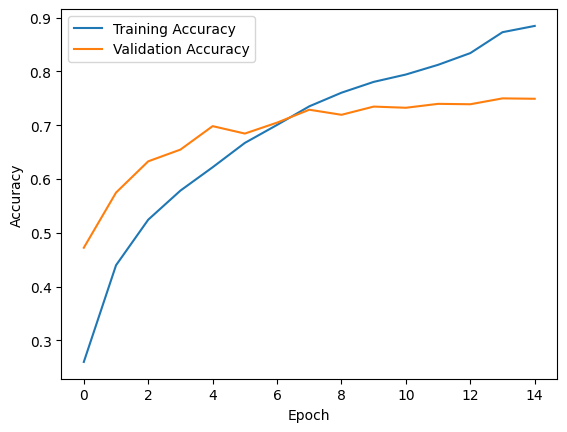

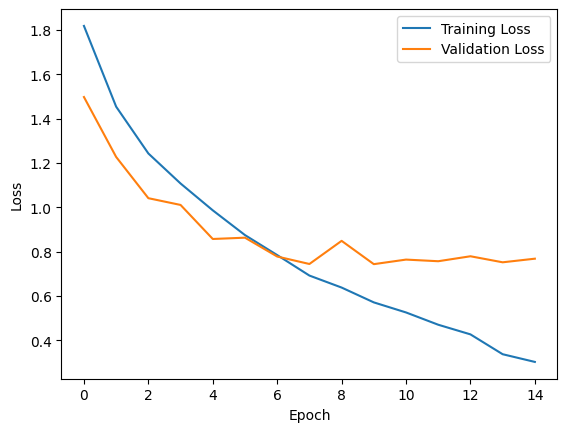

In [ ]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')  # Output layer with softmax activation for multi-class classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=100,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


1/1 [==============================] - 0s 28ms/step


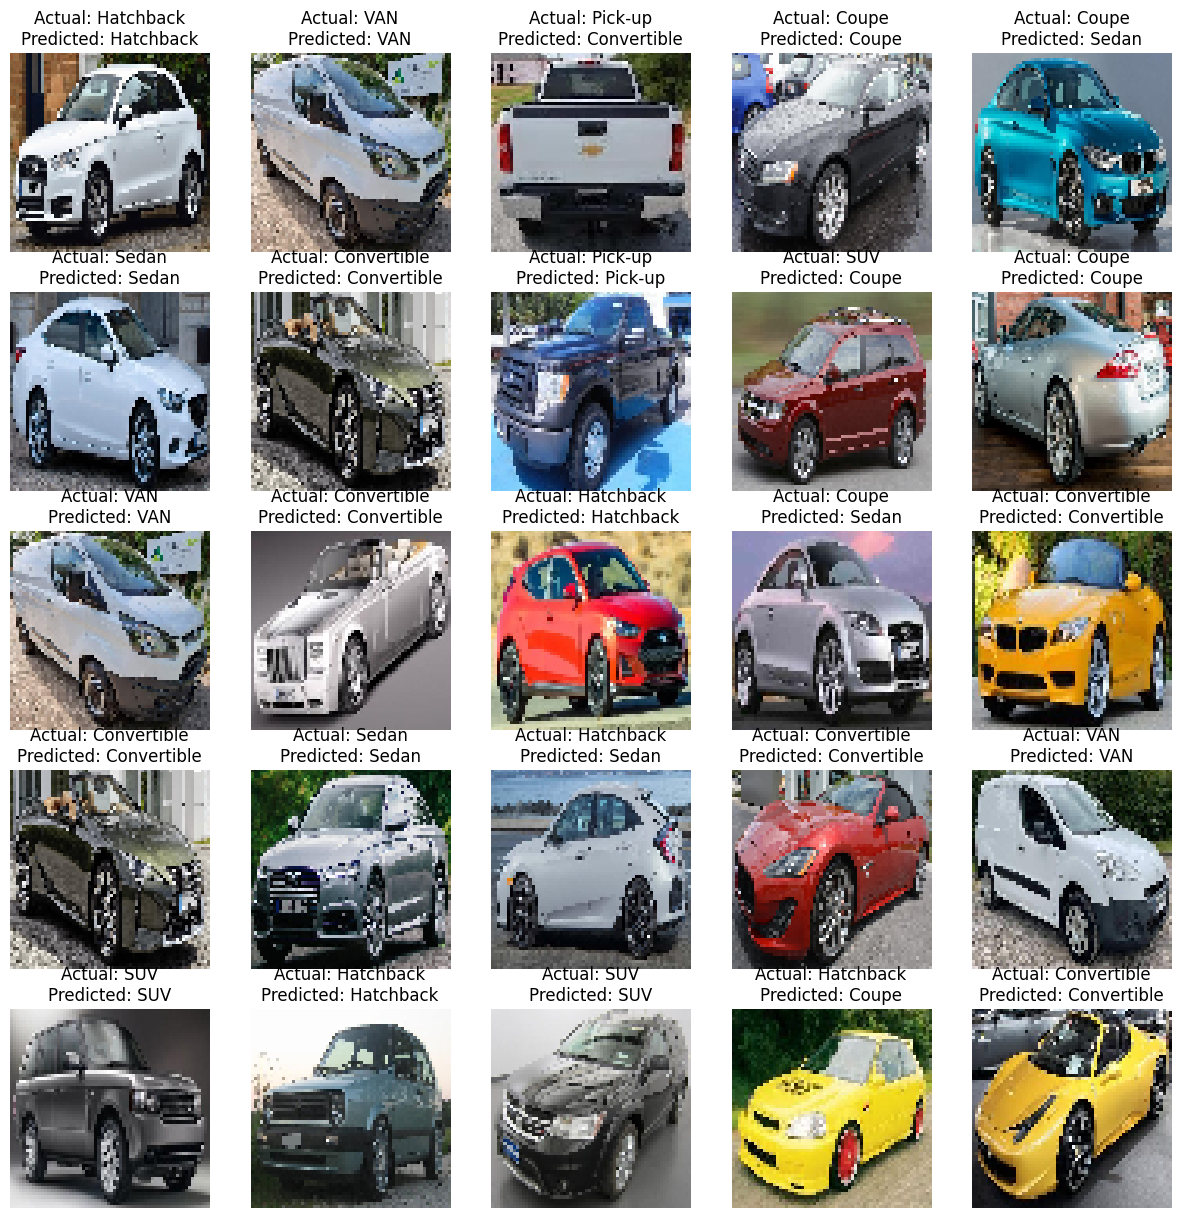

In [16]:
# Define the number of rows and columns for the grid
num_rows = 5
num_cols = 5

# Create an iterator from the test generator to access the test images and their labels
test_iterator = iter(test_generator)

# Create a figure with subplots for displaying the images in a grid
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

# Define class names
class_names = [
    "Convertible",
    "Coupe",
    "Hatchback",
    "Pick-up",
    "SUV",
    "Sedan",
    "VAN"
]

# Loop through the grid and display images with actual and predicted class labels
for row in range(num_rows):
    for col in range(num_cols):
        # Get a batch of images and labels from the test generator
        images, labels = next(test_iterator)

        # Select the first image from the batch
        sample_image = images[0]

        # Resize the image to the target shape (assuming your model expects 224x224 images)
        sample_image = tf.image.resize(sample_image, (64, 64))

        # Make a prediction using your loaded model
        predictions = model.predict(sample_image.numpy().reshape(1, 64, 64, 3))

        # Get the predicted class name
        predicted_class = class_names[np.argmax(predictions, axis=1)[0]]

        # Get the actual class name
        actual_class = class_names[np.argmax(labels[0])]

        # Display the image with the actual and predicted class names
        axes[row, col].imshow(sample_image.numpy())
        axes[row, col].set_title(f"Actual: {actual_class}\nPredicted: {predicted_class}")
        axes[row, col].axis('off')

plt.show()